In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import MazeEnvironment2
import seaborn as sns

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Q-Learning

In [3]:
# Q-Learning agent here
class QLearningAgent(BaseAgent):
    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions =  agent_info.get("num_actions", 4)
        self.num_states =  agent_info.get("num_states", 60)
        self.epsilon =  agent_info.get("epsilon", 0.1)
        self.step_size =  agent_info.get("step_size", 0.125)
        self.discount =  agent_info.get("discount", 0.95)
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.q[self.prev_state, self.prev_action] += self.step_size*(reward +
                                                           self.discount*max(current_q)
                                                          - self.q[self.prev_state, self.prev_action]) 
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size*(reward -
                                                                     self.q[self.prev_state, self.prev_action])  
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## semi-gradient Q-learning with tile coding 

In [4]:
import tiles3 as tc

In [5]:
class MazeTileCoder:
    def __init__(self, num_tilings=4, num_tiles=4):
        """
        Initializes the Maze Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht_size = num_tilings*(num_tiles+1)*(num_tiles+1)
        self.iht = tc.IHT(self.iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        
    def get_observation(self, state):
        return state//10, state%10
    
    def get_tiles(self, state):
        i_scale = self.num_tiles / 5
        j_scale = self.num_tiles / 9 
        
        position_i, position_j = self.get_observation(state)
        tiles = tc.tiles(self.iht, self.num_tilings, [(5 - position_i)*i_scale, 
                                                      position_j*j_scale])  
        return np.array(tiles)
    
    def get_state_vector(self, state):
        active_tile = self.get_tiles(state)
        vector = np.zeros(self.iht_size)
        vector[active_tile] = 1
        return vector

# Linear Q-Learning Agent 

In [10]:
# Create LinearQLearningAgent
class LinearQLearningAgent(BaseAgent):
        
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
    
        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        # Policy will be given, recall that the goal is to accurately estimate its corresponding value function. 
        self.num_actions = agent_info.get("num_actions", 4)
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount", 0.95)
        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size", 0.1/4)
        # epsilon
        self.epsilon = agent_info.get("epsilon", 0.1)
        
        # tiles
        self.num_tilings = agent_info.get("num_tilings", 4)
        self.num_tiles = agent_info.get("num_tiles", 4)
        
        # tile coder
        self.tc = MazeTileCoder(num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)
                # we have two features
        self.iht_size = self.tc.iht_size
        self.weights = np.ones((self.num_actions, self.iht_size)) * 0

        # stores all possible features
        # self.all_state_features = np.array([[i/6, j/10] for i in range(6) for j in range(10)])


        self.last_state = None
        self.last_action = None
        
    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        for action in range(self.num_actions):
            action_values.append(np.sum(self.weights[action][tiles]))
        if np.random.random() < self.epsilon:
            chosen_action =  np.random.randint(self.num_actions)
        else:
            chosen_action = self.argmax(action_values)
        
        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """
        
        self.last_state = state
        current_i = state//10
        current_j = state%10
        
        active_tiles = self.tc.get_tiles(state)
        current_action, current_value = self.select_action(active_tiles)
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        
        # get relevant feature
        current_i = state//10
        current_j = state%10
        # select action
        active_tiles = self.tc.get_tiles(state)
        current_action, current_value = self.select_action(active_tiles)
        
        self.weights[self.last_action][self.previous_tiles] += self.step_size*(reward + current_value*self.discount - np.sum(self.weights[self.last_action][self.previous_tiles]))

        self.last_state = state
        self.last_action = current_action
        self.previous_tiles = active_tiles
        
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.weights[self.last_action][self.previous_tiles] += self.step_size *(reward - np.sum(self.weights[self.last_action][self.previous_tiles]))

        return
        
    def agent_message(self, message):
        # We will implement this method later
        raise NotImplementedError
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


In [11]:
env = MazeEnvironment2
agents = {
    "Q-learning": QLearningAgent,
    "Linear-Q-learning": LinearQLearningAgent
}

In [15]:
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 60, "epsilon": 0.01, "step_size": 0.1, "discount": 0.95}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

In [16]:
algorithm = "Q-learning"
all_reward_sums[algorithm] = []
all_state_visits[algorithm] = []
for run in tqdm(range(num_runs)):
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    reward_sums = []
    state_visits = np.zeros(60)
#         last_episode_total_reward = 0
    for episode in range(num_episodes):
        if episode < num_episodes - 10:
            # Runs an episode
            rl_glue.rl_episode(0) 
        else: 
            # Runs an episode while keeping track of visited states
            state, action = rl_glue.rl_start()
            state_visits[state] += 1
            is_terminal = False
            while not is_terminal:
                reward, state, action, is_terminal = rl_glue.rl_step()
                state_visits[state] += 1

        reward_sums.append(rl_glue.rl_return())
#             last_episode_total_reward = rl_glue.rl_return()

    all_reward_sums[algorithm].append(reward_sums)
    
    all_state_visits[algorithm].append(state_visits)

# save results
import os
import shutil
os.makedirs('results', exist_ok=True)
np.save('results/q_learning.npy', all_reward_sums['Q-learning'])
shutil.make_archive('results', 'zip', '.', 'results')

100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


'/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Background/RL/Policy_Iteration/Maze/results.zip'

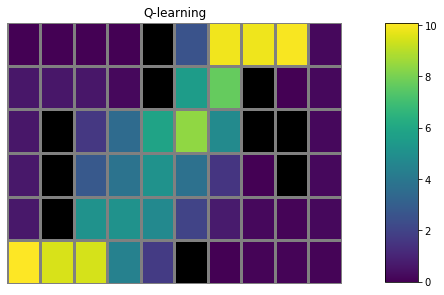

In [17]:
# Do not modify this cell!
for algorithm, position in [("Q-learning", 211)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((6,10))
    
    # gray the obstacles
    obstacles = [[2,1],[3,1],[4,1],[0,4],[1,4],[5,5],[1,7],[2,7],[2,8],[3,8]]
    for (i,j) in obstacles:
        grid_state_visits[i,j] = np.nan
    
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.gca().invert_yaxis()
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('black')

    plt.subplots_adjust(bottom=-1, right= 0.9, top=1)
    cax = plt.axes([1, 0.1, 0.075, 0.9])
cbar = plt.colorbar(cax=cax)
#cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.savefig('results/qlearning_visits.png', bbox_inches="tight")
plt.show()

In [13]:
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 60, "epsilon": 0.01, "step_size": 0.1/4, "discount": 0.95,
             "num_tiles": 7}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

In [14]:
algorithm = "Linear-Q-learning"
all_reward_sums[algorithm] = []
all_state_visits[algorithm] = []
for run in tqdm(range(num_runs)):
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    reward_sums = []
    state_visits = np.zeros(60)
#         last_episode_total_reward = 0
    for episode in range(num_episodes):
        if episode < num_episodes - 10:
            # Runs an episode
            rl_glue.rl_episode(0) 
        else: 
            # Runs an episode while keeping track of visited states
            state, action = rl_glue.rl_start()
            state_visits[state] += 1
            is_terminal = False
            while not is_terminal:
                reward, state, action, is_terminal = rl_glue.rl_step()
                state_visits[state] += 1

        reward_sums.append(rl_glue.rl_return())
#             last_episode_total_reward = rl_glue.rl_return()

    all_reward_sums[algorithm].append(reward_sums)
    all_state_visits[algorithm].append(state_visits)

# save results
import os
import shutil
os.makedirs('results', exist_ok=True)
np.save('results/q_learning.npy', all_reward_sums["Linear-Q-learning"])
#np.save('results/expected_sarsa.npy', all_reward_sums['Expected Sarsa'])
shutil.make_archive('results', 'zip', '.', 'results')


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


'/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Background/RL/Policy_Iteration/Maze/results.zip'

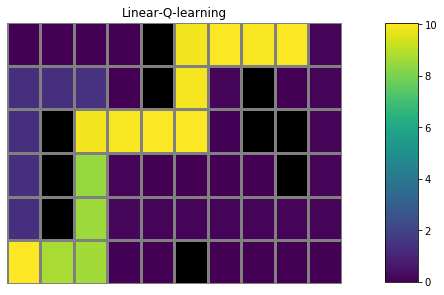

In [15]:
# Do not modify this cell!
for algorithm, position in [("Linear-Q-learning", 211)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((6,10))
    
    # gray the obstacles
    obstacles = [[2,1],[3,1],[4,1],[0,4],[1,4],[5,5],[1,7],[2,7],[2,8],[3,8]]
    for (i,j) in obstacles:
        grid_state_visits[i,j] = np.nan
    
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.gca().invert_yaxis()
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('black')

    plt.subplots_adjust(bottom=-1, right= 0.9, top=1)
    cax = plt.axes([1, 0.1, 0.075, 0.9])
cbar = plt.colorbar(cax=cax)
#cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.savefig('results/linearqlearning_visits.png', bbox_inches="tight")
plt.show()

In [151]:
num_runs = 100
num_episodes = 50
env_info = {}
agent_info = {"num_tiles": 4, "num_tilings": 4, "epsilon" : 0.01, "step_size" : 0.1}
all_steps = {}
for algorithm in ['Q-learning', 'Linear-Q-learning']:
    if algorithm == 'Linear-Q-learning':
        agent_info.update({"step_size": 0.1/4})
    agent = agents[algorithm]
    env = MazeEnvironment2
    steps = []
    for run in range(num_runs):
        agent_info["seed"] = run
        if run % 5 == 0:
            print("RUN: {}".format(run))

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        steps_per_episode = []

        for episode in range(num_episodes):
            rl_glue.rl_episode(15000)
            steps_per_episode.append(rl_glue.num_steps)

        steps.append(np.array(steps_per_episode))
    all_steps[algorithm] = steps

RUN: 0
RUN: 5
RUN: 10
RUN: 15
RUN: 20
RUN: 25
RUN: 30
RUN: 35
RUN: 40
RUN: 45
RUN: 50
RUN: 55
RUN: 60
RUN: 65
RUN: 70
RUN: 75
RUN: 80
RUN: 85
RUN: 90
RUN: 95
RUN: 0
RUN: 5
RUN: 10
RUN: 15
RUN: 20
RUN: 25
RUN: 30
RUN: 35
RUN: 40
RUN: 45
RUN: 50
RUN: 55
RUN: 60
RUN: 65
RUN: 70
RUN: 75
RUN: 80
RUN: 85
RUN: 90
RUN: 95


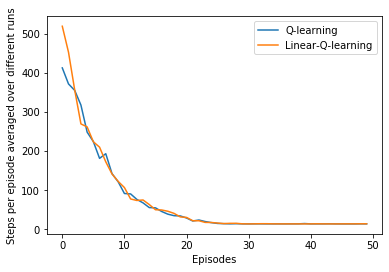

In [152]:
for algorithm in ['Q-learning', 'Linear-Q-learning']:
    plt.plot(np.mean(np.array(all_steps[algorithm]), axis=0), label = algorithm)
plt.legend()
plt.ylabel("Steps per episode averaged over different runs")
plt.xlabel("Episodes")
plt.savefig("results/steps_per_episode.png")